In [1]:
import matplotlib.pyplot as plt

# from common import *
from sklearn import metrics
import pandas as pd
import numpy as np
import cv2

In [2]:


#################################################################################################


def np_binary_cross_entropy_loss(probability, truth):
    probability = probability.astype(np.float64)
    probability = np.nan_to_num(probability, nan=1, posinf=1, neginf=0)

    p = np.clip(probability, 1e-5, 1 - 1e-5)
    y = truth

    loss = -y * np.log(p) - (1 - y) * np.log(1 - p)
    loss = loss.mean()
    return loss

def get_f1score(probability, truth, threshold = np.linspace(0, 1, 50)):
    f1score = []
    precision=[]
    recall=[]
    for t in threshold:
        predict = (probability > t).astype(np.float32)

        tp = ((predict >= 0.5) & (truth >= 0.5)).sum()
        fp = ((predict >= 0.5) & (truth < 0.5)).sum()
        fn = ((predict < 0.5) & (truth >= 0.5)).sum()

        r = tp / (tp + fn + 1e-3)
        p = tp / (tp + fp + 1e-3)
        f1 = 2 * r * p / (r + p + 1e-3)
        f1score.append(f1)
        precision.append(p)
        recall.append(r)
    f1score = np.array(f1score)
    precision = np.array(precision)
    recall = np.array(recall)
    return f1score, precision, recall, threshold

def plot_auc(cancer_p, cancer_t, figure_num):
    plt.figure(figure_num)
    spacing=50
    cancer_t = cancer_t.astype(int)
    pos, bin = np.histogram(cancer_p[cancer_t == 1], np.linspace(0, 1, spacing))
    neg, bin = np.histogram(cancer_p[cancer_t == 0], np.linspace(0, 1, spacing))
    pos = pos / (cancer_t == 1).sum()
    neg = neg / (cancer_t == 0).sum()
    #print(pos)
    #print(neg)
    # plt.plot(bin[1:],neg, alpha=1)
    # plt.plot(bin[1:],pos, alpha=1)
    bin = (bin[1:] + bin[:-1]) / 2
    plt.bar(bin, neg, width=1/spacing, label='neg', alpha=0.5)
    plt.bar(bin, pos, width=1/spacing, label='pos', alpha=0.5)
    plt.legend()
    #plt.yscale('log')
    # if is_show:
    #     plt.show()
    # return  plt.gcf()

def compute_metric(cancer_p, cancer_t):
    
    fpr, tpr, thresholds = metrics.roc_curve(cancer_t, cancer_p)
    auc = metrics.auc(fpr, tpr)

    f1score, precision, recall, threshold = get_f1score(cancer_p, cancer_t)
    i = f1score.argmax()
    f1score, precision, recall, threshold = f1score[i], precision[i], recall[i], threshold[i]

    specificity = ((cancer_p < threshold ) & ((cancer_t <= 0.5))).sum() / (cancer_t <= 0.5).sum()
    sensitivity = ((cancer_p >= threshold) & ((cancer_t >= 0.5))).sum() / (cancer_t >= 0.5).sum()

    return {
        'auc': auc,
        'threshold': threshold,
        'f1score': f1score,
        'precision': precision,
        'recall': recall,
        'sensitivity': sensitivity,
        'specificity': specificity,
    }

def compute_pfbeta(labels, predictions, beta=1):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
            #cfp += 1 - prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp+1e-8)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

def print_all_metric(valid_df):

    print(f'{"    ": <16}    \tauc      @th     f1      | 	prec    recall  | 	sens    spec ')
    #log.write(f'{"    ": <16}    \t0.77902	0.44898	0.28654 | 	0.32461	0.25726 | 	0.25726	0.98794\n')
    for site_id in [0,1,2]:

        #log.write(f'*** site_id [{site_id}] ***\n')
        #log.write(f'\n')

        if site_id>0:
            site_df = valid_df[valid_df.site_id == site_id].reset_index(drop=True)
        else:
            site_df = valid_df
        # ---
        gb = site_df
        m = compute_metric(gb.cancer_p, gb.cancer_t)
        text = f'{"single image": <16} [{site_id}]'
        text += f'\t{m["auc"]:0.5f}'
        text += f'\t{m["threshold"]:0.5f}'
        text += f'\t{m["f1score"]:0.5f} | '
        text += f'\t{m["precision"]:0.5f}'
        text += f'\t{m["recall"]:0.5f} | '
        text += f'\t{m["sensitivity"]:0.5f}'
        text += f'\t{m["specificity"]:0.5f}'
        #text += '\n'
        print(text)
        
        gb = site_df[['patient_id', 'laterality', 'cancer_t', 'cancer_p']].groupby(['patient_id', 'laterality']).mean()
        # m = compute_metric(gb.cancer_p.values, gb.cancer_t.values)
        try :
            m = compute_metric(gb.cancer_p.values, gb.cancer_t.values)
        except:
            gb = gb[gb.cancer_t.isin([0,1])]
            m = compute_metric(gb.cancer_p.values, gb.cancer_t.values)
            # m = compute_metric(gb.cancer_p.values, np.where(gb.cancer_t > 0.5, 1,0))
        text = f'{"grouby mean()": <16} [{site_id}]'
        text += f'\t{m["auc"]:0.5f}'
        text += f'\t{m["threshold"]:0.5f}'
        text += f'\t{m["f1score"]:0.5f} | '
        text += f'\t{m["precision"]:0.5f}'
        text += f'\t{m["recall"]:0.5f} | '
        text += f'\t{m["sensitivity"]:0.5f}'
        text += f'\t{m["specificity"]:0.5f}'
        #text += '\n'
        print(text)

        # ---
        gb = site_df[['patient_id', 'laterality', 'cancer_t', 'cancer_p']].groupby(['patient_id', 'laterality']).max()
        m = compute_metric(gb.cancer_p.values, gb.cancer_t.values)
        text = f'{"grouby max()": <16} [{site_id}]'
        text += f'\t{m["auc"]:0.5f}'
        text += f'\t{m["threshold"]:0.5f}'
        text += f'\t{m["f1score"]:0.5f} | '
        text += f'\t{m["precision"]:0.5f}'
        text += f'\t{m["recall"]:0.5f} | '
        text += f'\t{m["sensitivity"]:0.5f}'
        text += f'\t{m["specificity"]:0.5f}'
        #text += '\n'
        print(text)
        print(f'--------------\n')



In [3]:

# root_dir = 'output/train_crop_voilut_1536'
# root_dir = 'output/train_crop_voilut_1536_seresnext'
# root_dir =  'output/test_pipeline'
root_dir =  'output/boostingb4_2048'

iteration='swa'
df = pd.read_csv('input_data/master_kfold_data.csv')
# df = pd.read_csv('input_data/kfold_train.csv')
fold = 1 
epoch_ = 1
valid_df= df[df.kfold==fold]
cancer_t =     np.load(f'{root_dir}/checkpoint-fold-{fold}_true_val.npy',)
cancer_p =     np.load(f'{root_dir}/checkpoint-fold-{fold}_ddp_ep_{epoch_}_predictions.npy', )
label_ids = np.load(f'{root_dir}/checkpoint-fold-{fold}_label_ids.npy',)
#cancer_p =     np.load('/home/titanx/hengck/share1/kaggle/2022/rsna-breast-mammography/code/dummy-01/[notebook]/nextvit-b-1536-faster1/probability.npy')



#### load model and predict on hidden test

In [4]:
import config
import dataset

In [5]:
from model import RSNAModel
import torch
from apex import amp
import glob
from tqdm import tqdm

In [6]:

test_data = df.copy() #df[df.kfold==4]
test_data['dump_path'] = test_data.apply(lambda row : ''.join(config.IMG_PATH+'/'+str(row['patient_id'])+'/'+str(row['image_id'])+'.png'), axis=1)
test_data = test_data.reset_index(drop=True)

In [7]:
external_data = pd.read_csv('external_data/additional_train.csv')

In [8]:
external_data_paths = glob.glob("external_data/external_data_png/**/*.png",recursive=True)

In [9]:
external_data['dump_path'] = external_data_paths
external_data['site_id'] = [np.random.randint(1, 3) for _ in range(len(external_data))]

In [10]:
device = torch.device("cuda:9" if torch.cuda.is_available() else "cpu")

In [11]:
# img_ids = test_data[test_data['fold_1_pred'].isnull()]['image_id'].values

In [12]:
# image_id_to_look = [233203633,  427970946, 1845502573, 1036826199, 1856674878,
#         573137232, 1446998474, 1700246383]

In [13]:
# test_data = test_data[test_data.image_id.isin(img_ids)]

In [14]:

external_test_dataloader = dataset.RSNADataloader(external_data, 'dump_path', weights=None, transforms=config.VAL_TRANSFORM, test=True).fetch(
                batch_size=8, num_workers=0, shuffle=False, drop_last=False,validation=True)


test_dataloader = dataset.RSNADataloader(test_data, 'dump_path', weights=None, transforms=config.VAL_TRANSFORM, test=True).fetch(
                batch_size=8, num_workers=0, shuffle=False, drop_last=False,validation=True)

In [15]:
# initialize CNN, cost, and optimizer
model = RSNAModel(output_size = 1,n_cols=len(config.CATEGORY_AUX_TARGETS)).to(device)

# model.load_state_dict(torch.load(f'{root_dir}/checkpoint-fold-{fold}_ddp_ep_{epoch_}_model.bin',map_location=device))

In [16]:
def get_prediction(model, data_laoder):
    model.eval()
    predictions = []
    with torch.inference_mode():
        # with torch.autocast(device_type='cuda'):
            for data in tqdm(data_laoder, total=len(data_laoder)):
                for k, v in data.items():
                    data[k] = v.to(device)

                outputs, _ = model(image=data['image'],meta=data['meta'])
                #2 tta
                # outputs_, _  = model(torch.flip(data['image'], dims=[3]))
                # outputs = (outputs + outputs_)/2.0
                outputs = torch.sigmoid(outputs)

                output = outputs.detach().cpu().numpy()
                predictions.append(output)
    return np.concatenate(predictions, axis=0)

        

In [17]:
MODEL_PATHS = [
                f'{root_dir}/checkpoint-fold-0_ddp_ep_2_model.bin',
              f'{root_dir}/checkpoint-fold-1_ddp_ep_1_model.bin',
              f'{root_dir}/checkpoint-fold-2_ddp_ep_3_model.bin',
              f'{root_dir}/checkpoint-fold-3_ddp_ep_2_model.bin'
                ]

In [18]:

def get_preds_folds(data_loader):
      
    raw_preds = []

    for idx , model_filename in enumerate(MODEL_PATHS): ## nfolds = config.NFOLDS = 5
        
        print(f"{model_filename}+>>> inference")
        model.load_state_dict(torch.load(model_filename,map_location=device))
        print("model loaded successfully")
        predictions = get_prediction(model, data_loader)
        raw_preds.append(predictions)


        del predictions #, pred_logits
        torch.cuda.empty_cache()
    
    return raw_preds


In [19]:
# preds_external = get_prediction(external_test_dataloader)

In [20]:
preds = get_preds_folds(test_dataloader)

output/boostingb4_2048/checkpoint-fold-0_ddp_ep_2_model.bin+>>> inference
model loaded successfully


100%|██████████| 6983/6983 [53:19<00:00,  2.18it/s]


output/boostingb4_2048/checkpoint-fold-1_ddp_ep_1_model.bin+>>> inference
model loaded successfully


100%|██████████| 6983/6983 [53:04<00:00,  2.19it/s]


output/boostingb4_2048/checkpoint-fold-2_ddp_ep_3_model.bin+>>> inference
model loaded successfully


100%|██████████| 6983/6983 [53:06<00:00,  2.19it/s]


output/boostingb4_2048/checkpoint-fold-3_ddp_ep_2_model.bin+>>> inference
model loaded successfully


100%|██████████| 6983/6983 [53:05<00:00,  2.19it/s]


In [28]:
predictions_all = np.mean(preds,axis=0)
# prediction_external = np.concatenate(preds_external, axis=0)

In [21]:
for i in range(len(preds)):
    test_data[f'fold_{i}_pred'] = preds[i]

In [22]:
test_data.to_csv('output/oof_test_data_all.csv',index=False)

In [29]:
predictions_all.shape

(11174, 1)

In [35]:
# load_img = cv2.imread(f'{config.IMG_PATH}/53468/1992149182.png')

In [36]:
# test_data = test_data[~test_data.cancer_p.isnull()]

In [37]:
# external_data['cancer_p'] = prediction_external
# external_data['cancer_t'] = 1

cancer_p
0           6705
1           4469
dtype: int64

In [20]:
test_data['cancer_p'] = predictions_all

In [21]:
test_data['cancer_t'] = test_data['cancer']

In [22]:
test_data[test_data.cancer_p.isnull()] 

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,...,machine_id,difficult_negative_case,orientation,orignal_path,dump_path,kfold,mean_age,weights,cancer_p,cancer_t


In [63]:
test_data['cancer_p'] = np.where(test_data['cancer_p']>0.5,1,0)

In [53]:
metrics.confusion_matrix(external_data['cancer_t'],np.where(external_data['cancer_p']>0.5,1,0))

array([[  0,   0],
       [768, 606]])

In [56]:
metrics.confusion_matrix(test_data['cancer_t'],np.where(test_data['cancer_p']>0.3,1,0))

array([[10633,    77],
       [  198,   266]])

In [64]:
metrics.confusion_matrix(test_data['cancer_t'],np.where(test_data['cancer_p']>0.5,1,0))

array([[10668,    42],
       [  205,   259]])

In [65]:
compute_pfbeta(test_data['cancer_t'], test_data['cancer_p'])

0.6771241829976846

In [35]:
# compute_pfbeta(external_data['cancer_t'], external_data['cancer_p'])

In [58]:
# import torch

In [41]:
check_df = pd.DataFrame(label_ids,columns=['image_id'])
check_df['cancer_p'] = cancer_p
check_df['cancer_t'] = cancer_t

In [42]:
len(cancer_t) , len(cancer_p), valid_df.shape

(11165, 11165, (11165, 20))

In [43]:
check_df.shape

(11165, 3)

In [44]:
duplicates = check_df.duplicated()

In [45]:
check_df[duplicates]

,image_id,cancer_p,cancer_t
11162,8255560.0,0.001106,0.0


In [46]:
check_df['image_id'].nunique() , valid_df['image_id'].nunique()

(11157, 11165)

In [47]:
check_df.drop_duplicates(inplace=True)

In [48]:
# For investigaton
# valid_df[~valid_df.image_id.isin(check_df['image_id'].unique())]

In [49]:
valid_df = valid_df.merge(check_df, on="image_id")

In [50]:
valid_df['check_flag'] = valid_df['cancer_t'].astype(int) == valid_df['cancer'].astype(int)

In [51]:
valid_df.shape

(404, 23)

In [52]:
valid_df['BIRADS'].value_counts()

1.0    109
0.0     62
2.0     20
Name: BIRADS, dtype: int64

In [53]:
valid_df[valid_df.cancer==1]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,...,difficult_negative_case,orientation,orignal_path,dump_path,kfold,mean_age,weights,cancer_p,cancer_t,check_flag
7,1,28989,382116832,1,1,52.0,1,1,1,0.0,...,False,R-CC,input_data/train_images/28989/382116832.dcm,input_data/train_images_png/28989/382116832.png,0,57.268687,3,0.846700,1.0,True
13,1,3542,593840512,1,1,68.0,1,1,1,0.0,...,False,R-CC,input_data/train_images/3542/593840512.dcm,input_data/train_images_png/3542/593840512.png,0,56.296552,3,0.554545,1.0,True
100,1,3542,14104315,1,0,68.0,1,1,1,0.0,...,False,R-MLO,input_data/train_images/3542/14104315.dcm,input_data/train_images_png/3542/14104315.png,0,56.296552,3,0.009511,1.0,True
150,2,23101,22058316,1,1,84.0,1,1,1,NaN,...,False,R-CC,input_data/train_images/23101/22058316.dcm,input_data/train_images_png/23101/22058316.png,0,59.153744,3,0.999707,1.0,True
161,2,53946,1239100800,0,1,64.0,1,1,1,NaN,...,False,L-CC,input_data/train_images/53946/1239100800.dcm,input_data/train_images_png/53946/1239100800.png,0,60.198516,3,0.016631,1.0,True
204,1,32740,208676208,1,0,77.0,1,1,1,0.0,...,False,R-MLO,input_data/train_images/32740/208676208.dcm,input_data/train_images_png/32740/208676208.png,0,57.268687,3,0.061983,1.0,True
238,2,6038,39672040,0,0,67.0,1,1,0,NaN,...,False,L-MLO,input_data/train_images/6038/39672040.dcm,input_data/train_images_png/6038/39672040.png,0,60.435452,3,0.869812,1.0,True
260,1,28057,1858505984,1,0,73.0,1,1,0,0.0,...,False,R-MLO,input_data/train_images/28057/1534271742.dcm,input_data/train_cropped_1536/28057/1534271742...,0,57.268687,3,0.981928,1.0,True
313,1,12725,480261408,0,0,60.0,1,1,1,0.0,...,False,L-MLO,input_data/train_images/12725/156027166.dcm,input_data/train_cropped_1536/12725/156027166.png,0,57.268687,3,0.963183,1.0,True
319,1,39702,1888808064,1,0,79.0,1,1,0,0.0,...,False,R-MLO,input_data/train_images/39702/1888808064.dcm,input_data/train_images_png/39702/1888808064.png,0,57.268687,3,0.976107,1.0,True


In [54]:
# valid_df.shape

In [55]:
for site_id in [1]:

        #log.write(f'*** site_id [{site_id}] ***\n')
        #log.write(f'\n')

        if site_id>0:
            site_df = valid_df[valid_df.site_id == site_id].reset_index(drop=True)
        else:
            site_df = valid_df
        # ---
        gb = site_df[['patient_id', 'laterality', 'cancer_t', 'cancer_p']].groupby(['patient_id', 'laterality']).mean()
        if site_id ==0:
            break
            m = compute_metric(gb.cancer_p.values, gb.cancer_t.values)
        
        

In [56]:
metrics.confusion_matrix(site_df['cancer_t'],np.where(site_df['cancer_p']>0.3,1,0))

array([[196,  13],
       [  3,   5]])

In [57]:
metrics.recall_score(site_df['cancer_t'],np.where(site_df['cancer_p']>0.3,1,0))

0.625

In [58]:
metrics.precision_score(site_df['cancer_t'],np.where(site_df['cancer_p']>0.3,1,0))

0.2777777777777778

In [59]:
compute_pfbeta(site_df['cancer_t'],np.where(site_df['cancer_p']>0.5,1,0))

0.45454545433884297

In [60]:
# gb[~gb.cancer_t.isin([0,1])]

In [61]:
valid_df.kfold.value_counts()

0    404
Name: kfold, dtype: int64

In [62]:
len(cancer_p), len(cancer_t)

(11165, 11165)

In [63]:
# num_samples = 10934
# world_size = 8
# VALID_BATCH_SIZE = 36

In [64]:
# import torch

In [65]:
# cancer_p = cancer_p[0:len(valid_df)]
# cancer_t = cancer_t[0:len(valid_df)]


In [66]:
valid_df['check_flag'].value_counts()

True    404
Name: check_flag, dtype: int64

In [67]:
# Sanity checks

In [68]:
valid_df.cancer_t.value_counts()

0.0    389
1.0     15
Name: cancer_t, dtype: int64

[]

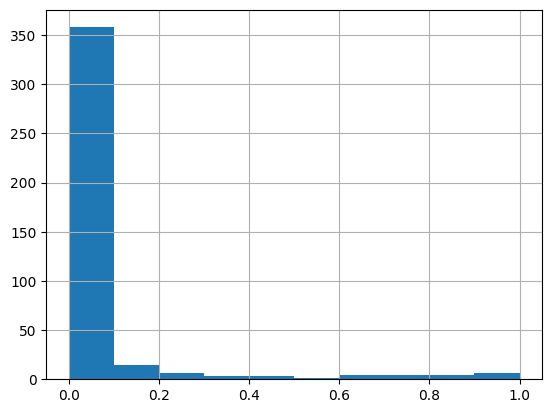

In [69]:
valid_df['cancer_p'].hist().plot()

In [70]:
# valid_df[(valid_df.cancer_t==0) & (valid_df.cancer==1)][['image_id','cancer','cancer_t','check_flag']]

In [71]:
# 22 @ 85 thresh

                    	auc      @th     f1      | 	prec    recall  | 	sens    spec 
single image     [0]	0.89169	0.81633	0.55948 | 	0.69993	0.46664 | 	0.46667	0.99229
grouby mean()    [0]	0.89985	0.81633	0.58280 | 	0.69993	0.49996 | 	0.50000	0.99206
grouby max()     [0]	0.90060	0.81633	0.58280 | 	0.69993	0.49996 | 	0.50000	0.99206
--------------

single image     [1]	0.85467	0.81633	0.53276 | 	0.57135	0.49994 | 	0.50000	0.98565
grouby mean()    [1]	0.87045	0.81633	0.57085 | 	0.57135	0.57135 | 	0.57143	0.98529
grouby max()     [1]	0.87325	0.81633	0.57085 | 	0.57135	0.57135 | 	0.57143	0.98529
--------------

single image     [2]	0.95079	0.44898	0.66607 | 	0.79984	0.57135 | 	0.57143	0.99444
grouby mean()    [2]	0.94992	0.44898	0.66607 | 	0.79984	0.57135 | 	0.57143	0.99425
grouby max()     [2]	0.94910	0.44898	0.66607 | 	0.79984	0.57135 | 	0.57143	0.99425
--------------

grouby mean()   	0.89985	0.81633	0.58280 | 	0.69993	0.49996 | 	0.50000	0.99206

pfbeta 0.40642621579903415
0.58279901764002

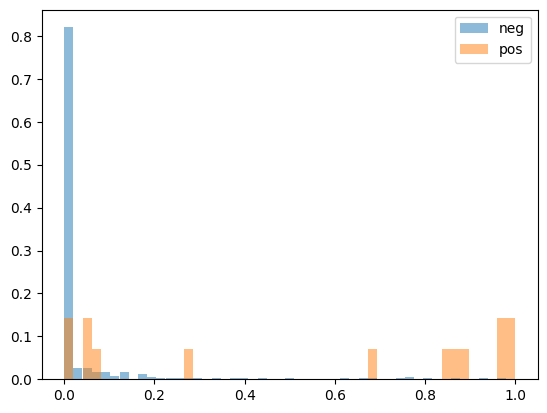

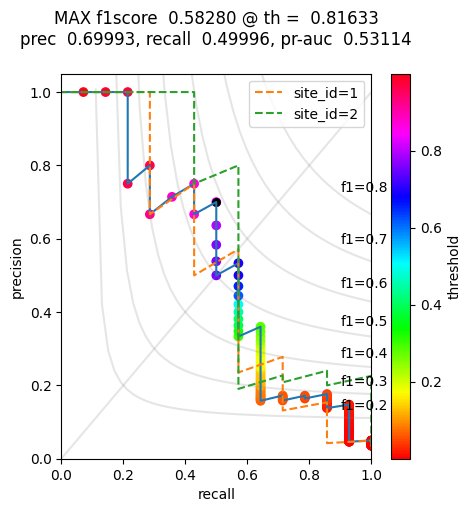

In [72]:
#--------------------------

# valid_df.loc[:, 'cancer_p'] = cancer_p #**0.5 #(cancer_p1 +cancer_p)/2 #cancer_p#
# valid_df.loc[:, 'cancer_t'] = cancer_t
print_all_metric(valid_df)


gb = valid_df[['site_id', 'patient_id','laterality', 'cancer_t', 'cancer_p']].groupby(['patient_id', 'laterality']).mean()
gb.loc[:, 'cancer_t'] = gb.cancer_t.astype(int)
m = compute_metric(gb.cancer_p, gb.cancer_t)
text = f'{"grouby mean()": <16}'
text += f'\t{m["auc"]:0.5f}'
text += f'\t{m["threshold"]:0.5f}'
text += f'\t{m["f1score"]:0.5f} | '
text += f'\t{m["precision"]:0.5f}'
text += f'\t{m["recall"]:0.5f} | '
text += f'\t{m["sensitivity"]:0.5f}'
text += f'\t{m["specificity"]:0.5f}'
text += '\n'
print(text)

pfbeta = compute_pfbeta(gb.cancer_t.values, gb.cancer_p.values, beta=1)
print('pfbeta',pfbeta)
plot_auc(gb.cancer_p, gb.cancer_t, figure_num=100)


f1score, precision, recall, threshold = get_f1score(gb.cancer_p, gb.cancer_t)
i = f1score.argmax()
f1score_max, precision_max, recall_max, threshold_max = f1score[i], precision[i], recall[i], threshold[i]
print(f1score_max, precision_max, recall_max, threshold_max)

precision, recall, threshold = metrics.precision_recall_curve(gb.cancer_t, gb.cancer_p)
auc = metrics.auc(recall, precision)

_, ax = plt.subplots(figsize=(5, 5))

f_scores = [0.2,0.3,0.4,0.5,0.6,0.7,0.8] #np.linspace(0.2, 0.8, num=8)
print(f_scores)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))
ax.plot([0,1],[0,1], color="gray", alpha=0.2)
ax.plot(recall,precision)
s=ax.scatter(recall[:-1],precision[:-1],c=threshold,cmap='hsv')
ax.scatter(recall_max, precision_max,s=30,c='k')

#---
precision, recall, threshold = metrics.precision_recall_curve(gb.cancer_t[gb.site_id==1], gb.cancer_p[gb.site_id==1])
ax.plot(recall,precision, '--', label='site_id=1')
precision, recall, threshold = metrics.precision_recall_curve(gb.cancer_t[gb.site_id==2], gb.cancer_p[gb.site_id==2])
ax.plot(recall,precision, '--', label='site_id=2')




ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

text=''
text+=f'MAX f1score {f1score_max: 0.5f} @ th = {threshold_max: 0.5f}\n'
text+=f'prec {precision_max: 0.5f}, recall {recall_max: 0.5f}, pr-auc {auc: 0.5f}\n'

plt.legend()
plt.title(text)
plt.colorbar(s,label='threshold')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()


In [58]:
# 31@50

## Old

In [22]:
test_data.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,...,machine_id,difficult_negative_case,orientation,orignal_path,dump_path,kfold,mean_age,weights,cancer_p,cancer_t
0,1,52479,750902630,0,0,55.0,0,0,0,1.0,...,49,False,L-MLO,input_data/train_images/52479/750902630.dcm,input_data/train_crop_voilut_2048/52479/750902...,4,57.268687,1,0.001748,0
1,1,50741,2022788221,0,1,46.0,0,0,0,NaN,...,49,False,L-CC,input_data/train_images/50741/2022788221.dcm,input_data/train_crop_voilut_2048/50741/202278...,4,57.268687,1,0.009636,0
2,1,36853,1043124373,0,1,59.0,0,0,0,1.0,...,49,False,L-CC,input_data/train_images/36853/1043124373.dcm,input_data/train_crop_voilut_2048/36853/104312...,4,57.268687,1,0.069946,0
3,2,36713,204228793,1,1,65.0,0,0,0,NaN,...,29,False,R-CC,input_data/train_images/36713/204228793.dcm,input_data/train_crop_voilut_2048/36713/204228...,4,59.153744,1,0.056854,0
4,2,60227,1390966811,1,0,51.0,0,0,0,0.0,...,21,True,R-MLO,input_data/train_images/60227/1390966811.dcm,input_data/train_crop_voilut_2048/60227/139096...,4,60.198516,1,0.008675,0


In [114]:
test_data['cancer_p'] = predictions_all
test_data['cancer_t'] = test_data['cancer']

In [103]:
test_data['cancer_p'] = np.where(test_data['cancer_p']>0.6,1,0)

In [104]:
test_data['cancer_p'].value_counts()

0    10875
1      299
Name: cancer_p, dtype: int64

In [109]:
gb = test_data[['site_id', 'patient_id','laterality', 'cancer_t', 'cancer_p']].groupby(['patient_id', 'laterality']).max()#.reset_index()
gb.loc[:, 'cancer_t'] = gb.cancer_t.astype(int)

In [110]:
th = np.quantile(gb['cancer_p'].values,0.97)
gb['cancer_binarize']= (gb['cancer_p'].values > th).astype(int)



In [111]:
th

0.9820312500000004

In [100]:
test_data[test_data.patient_id==106]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,...,machine_id,difficult_negative_case,orientation,orignal_path,dump_path,kfold,mean_age,weights,cancer_p,cancer_t
112,2,106,1495797827,1,0,65.0,0,0,0,NaN,...,21,False,R-MLO,input_data/train_images/106/1495797827.dcm,input_data/train_crop_voilut_2048/106/14957978...,4,60.198516,1,0.028702,0
639,2,106,2343060234,1,0,65.0,1,1,1,NaN,...,21,False,R-MLO,input_data/train_images/106/2018825992.dcm,input_data/train_crop_voilut_2048/106/23430602...,4,60.198516,3,1.000000,1
1257,2,106,400556009,1,1,65.0,1,1,1,NaN,...,21,False,R-CC,input_data/train_images/106/76321767.dcm,input_data/train_crop_voilut_2048/106/40055600...,4,60.198516,3,1.000000,1
3464,2,106,76321767,0,1,65.0,1,1,1,NaN,...,21,False,L-CC,input_data/train_images/106/76321767.dcm,input_data/train_crop_voilut_2048/106/76321767...,4,60.198516,3,0.196045,1
4199,2,106,1160585918,1,1,65.0,0,0,0,NaN,...,21,False,R-CC,input_data/train_images/106/1160585918.dcm,input_data/train_crop_voilut_2048/106/11605859...,4,60.198516,1,0.004314,0
6982,2,106,2018825992,0,0,65.0,1,1,1,NaN,...,21,False,L-MLO,input_data/train_images/106/2018825992.dcm,input_data/train_crop_voilut_2048/106/20188259...,4,60.198516,3,0.015190,1


In [112]:
gb_data  = gb.reset_index()

In [113]:
gb_data[gb_data.patient_id==106]

,patient_id,laterality,site_id,cancer_t,cancer_p,cancer_binarize
8,106,0,2,1,0.196045,0
9,106,1,2,1,1.000000,1


In [114]:
gb[gb.cancer_t ==1]#['cancer_binarize'].sum()

site_id  cancer_t  cancer_p  cancer_binarize
patient_id laterality                                              
106        0                 2         1  0.196045                0
           1                 2         1  1.000000                1
865        0                 2         1  1.000000                1
           1                 2         1  0.948730                0
1878       0                 1         1  0.981934                0
...                        ...       ...       ...              ...
64437      1                 2         1  1.000000                1
64534      0                 1         1  0.463867                0
           1                 1         1  1.000000                1
65492      0                 2         1  0.811035                0
           1                 2         1  1.000000                1

[194 rows x 4 columns]

In [115]:
compute_pfbeta(gb['cancer_t'].values, gb['cancer_binarize'].values)


0.7240356082871204

In [116]:
test_data['cancer_t'].value_counts()

0    10710
1      464
Name: cancer_t, dtype: int64

In [110]:
conf_m = metrics.confusion_matrix(test_data['cancer_t'],np.where(test_data['cancer_p']>0.,1,0))

In [111]:
conf_m.sum() - conf_m.diagonal().sum()

469

In [112]:
conf_m


array([[10463,   247],
       [  222,   242]])

In [123]:
compute_pfbeta(test_data['cancer_t'].values,np.where(test_data['cancer_p']>0.5,1,0))

0.5410036719640025

In [97]:
gb['cancer_t'].value_counts()

0    4572
1     194
Name: cancer_t, dtype: int64

In [70]:
gb['cancer_p'].value_counts()

0.092346    24
0.099976    23
0.098450    23
0.102112    23
0.101074    22
            ..
0.185303     1
0.966797     1
0.200684     1
0.176147     1
0.503906     1
Name: cancer_p, Length: 1134, dtype: int64

In [55]:
# metrics.confusion_matrix(gb['cancer_t'],gb['cancer_p'])

In [84]:
metrics.confusion_matrix(gb['cancer_t'],np.where(gb['cancer_p']>0.6,1,0))

array([[4477,   95],
       [  62,  132]])

In [68]:
metrics.confusion_matrix(gb['cancer_t'],gb['cancer_p'])

array([[4494,   78],
       [  53,  141]])

In [88]:
compute_pfbeta(gb['cancer_t'].values,np.where(gb['cancer_p']>0.6,1,0))

0.6270783847832048

In [75]:
gb[gb['cancer_t']==1]

site_id  cancer_t  cancer_p
patient_id laterality                             
106        0                 2         1         0
           1                 2         1         1
865        0                 2         1         1
           1                 2         1         0
1878       0                 1         1         0
...                        ...       ...       ...
64437      1                 2         1         1
64534      0                 1         1         0
           1                 1         1         1
65492      0                 2         1         0
           1                 2         1         1

[194 rows x 3 columns]

                    	auc      @th     f1      | 	prec    recall  | 	sens    spec 
single image     [0]	0.95067	0.87755	0.71051 | 	0.80992	0.63362 | 	0.63362	0.99356
grouby mean()    [0]	0.95956	0.38776	0.52671 | 	0.44681	0.64285 | 	0.64286	0.98294
grouby max()     [0]	0.97632	0.97959	0.72517 | 	0.84827	0.63402 | 	0.63918	0.99519
--------------

single image     [1]	0.93589	0.97959	0.66036 | 	0.86285	0.53546 | 	0.53546	0.99584
grouby mean()    [1]	0.94498	0.38776	0.41381 | 	0.33333	0.54716 | 	0.54717	0.97392
grouby max()     [1]	0.96764	0.97959	0.66617 | 	0.75903	0.59433 | 	0.59434	0.99101
--------------

single image     [2]	0.97116	0.77551	0.79461 | 	0.89655	0.71428 | 	0.71429	0.99696
grouby mean()    [2]	0.96888	0.48980	0.69949 | 	0.79998	0.62221 | 	0.62222	0.99702
grouby max()     [2]	0.98236	0.93878	0.83699 | 	0.93054	0.76135 | 	0.76136	0.99787
--------------

grouby mean()   	0.94869	0.53061	0.42218 | 	0.42708	0.41836 | 	0.41837	0.98822

pfbeta 0.24385512389882247
0.42217669867072

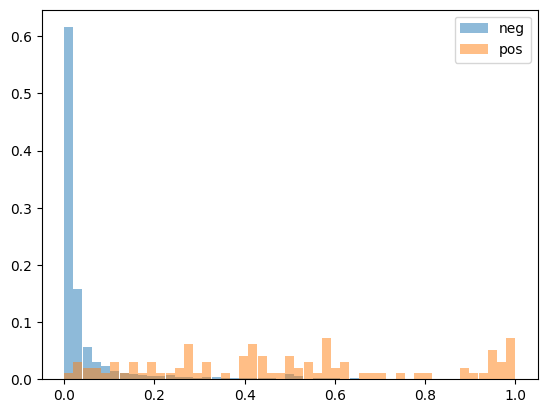

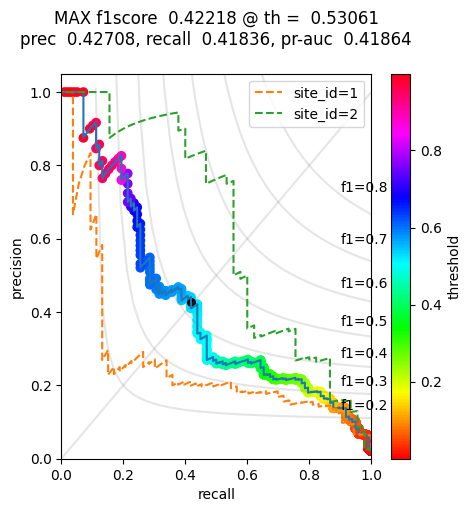

In [23]:
#--------------------------

# valid_df.loc[:, 'cancer_p'] = cancer_p #**0.5 #(cancer_p1 +cancer_p)/2 #cancer_p#
# valid_df.loc[:, 'cancer_t'] = cancer_t
print_all_metric(test_data)


gb = test_data[['site_id', 'patient_id','laterality', 'cancer_t', 'cancer_p']].groupby(['patient_id', 'laterality']).mean()
gb.loc[:, 'cancer_t'] = gb.cancer_t.astype(int)
m = compute_metric(gb.cancer_p, gb.cancer_t)
text = f'{"grouby mean()": <16}'
text += f'\t{m["auc"]:0.5f}'
text += f'\t{m["threshold"]:0.5f}'
text += f'\t{m["f1score"]:0.5f} | '
text += f'\t{m["precision"]:0.5f}'
text += f'\t{m["recall"]:0.5f} | '
text += f'\t{m["sensitivity"]:0.5f}'
text += f'\t{m["specificity"]:0.5f}'
text += '\n'
print(text)

pfbeta = compute_pfbeta(gb.cancer_t.values, gb.cancer_p.values, beta=1)
print('pfbeta',pfbeta)
plot_auc(gb.cancer_p, gb.cancer_t, figure_num=100)


f1score, precision, recall, threshold = get_f1score(gb.cancer_p, gb.cancer_t)
i = f1score.argmax()
f1score_max, precision_max, recall_max, threshold_max = f1score[i], precision[i], recall[i], threshold[i]
print(f1score_max, precision_max, recall_max, threshold_max)

precision, recall, threshold = metrics.precision_recall_curve(gb.cancer_t, gb.cancer_p)
auc = metrics.auc(recall, precision)

_, ax = plt.subplots(figsize=(5, 5))

f_scores = [0.2,0.3,0.4,0.5,0.6,0.7,0.8] #np.linspace(0.2, 0.8, num=8)
print(f_scores)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))
ax.plot([0,1],[0,1], color="gray", alpha=0.2)
ax.plot(recall,precision)
s=ax.scatter(recall[:-1],precision[:-1],c=threshold,cmap='hsv')
ax.scatter(recall_max, precision_max,s=30,c='k')

#---
precision, recall, threshold = metrics.precision_recall_curve(gb.cancer_t[gb.site_id==1], gb.cancer_p[gb.site_id==1])
ax.plot(recall,precision, '--', label='site_id=1')
precision, recall, threshold = metrics.precision_recall_curve(gb.cancer_t[gb.site_id==2], gb.cancer_p[gb.site_id==2])
ax.plot(recall,precision, '--', label='site_id=2')




ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

text=''
text+=f'MAX f1score {f1score_max: 0.5f} @ th = {threshold_max: 0.5f}\n'
text+=f'prec {precision_max: 0.5f}, recall {recall_max: 0.5f}, pr-auc {auc: 0.5f}\n'

plt.legend()
plt.title(text)
plt.colorbar(s,label='threshold')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [ ]:
#36 @30 effnetb4 4

                    	auc      @th     f1      | 	prec    recall  | 	sens    spec 
single image     [0]	0.95067	0.87755	0.71051 | 	0.80992	0.63362 | 	0.63362	0.99356
grouby mean()    [0]	0.95956	0.38776	0.52671 | 	0.44681	0.64285 | 	0.64286	0.98294
grouby max()     [0]	0.97632	0.97959	0.72517 | 	0.84827	0.63402 | 	0.63918	0.99519
--------------

single image     [1]	0.93589	0.97959	0.66036 | 	0.86285	0.53546 | 	0.53546	0.99584
grouby mean()    [1]	0.94498	0.38776	0.41381 | 	0.33333	0.54716 | 	0.54717	0.97392
grouby max()     [1]	0.96764	0.97959	0.66617 | 	0.75903	0.59433 | 	0.59434	0.99101
--------------

single image     [2]	0.97116	0.77551	0.79461 | 	0.89655	0.71428 | 	0.71429	0.99696
grouby mean()    [2]	0.96888	0.48980	0.69949 | 	0.79998	0.62221 | 	0.62222	0.99702
grouby max()     [2]	0.98236	0.93878	0.83699 | 	0.93054	0.76135 | 	0.76136	0.99787
--------------

grouby mean()   	0.97632	0.97959	0.72517 | 	0.84827	0.63402 | 	0.63918	0.99519

pfbeta 0.4545354706334012
0.725170211867391

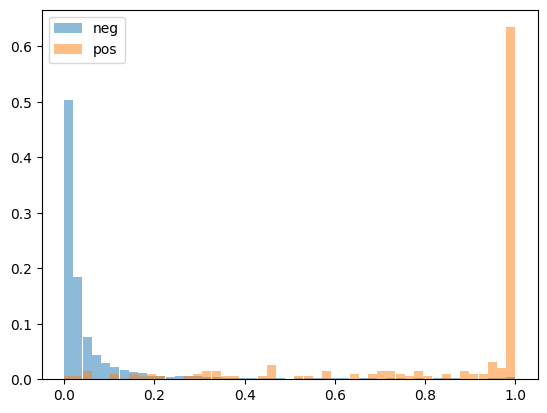

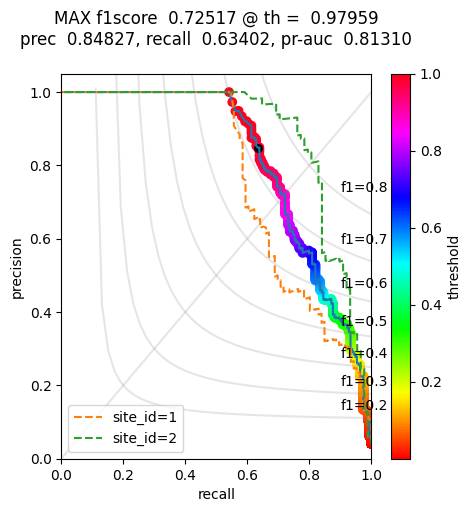

In [24]:
#--------------------------

# valid_df.loc[:, 'cancer_p'] = cancer_p #**0.5 #(cancer_p1 +cancer_p)/2 #cancer_p#
# valid_df.loc[:, 'cancer_t'] = cancer_t
print_all_metric(test_data)


gb = test_data[['site_id', 'patient_id','laterality', 'cancer_t', 'cancer_p']].groupby(['patient_id', 'laterality']).max()
gb.loc[:, 'cancer_t'] = gb.cancer_t.astype(int)
m = compute_metric(gb.cancer_p, gb.cancer_t)
text = f'{"grouby mean()": <16}'
text += f'\t{m["auc"]:0.5f}'
text += f'\t{m["threshold"]:0.5f}'
text += f'\t{m["f1score"]:0.5f} | '
text += f'\t{m["precision"]:0.5f}'
text += f'\t{m["recall"]:0.5f} | '
text += f'\t{m["sensitivity"]:0.5f}'
text += f'\t{m["specificity"]:0.5f}'
text += '\n'
print(text)

pfbeta = compute_pfbeta(gb.cancer_t.values, gb.cancer_p.values, beta=1)
print('pfbeta',pfbeta)
plot_auc(gb.cancer_p, gb.cancer_t, figure_num=100)


f1score, precision, recall, threshold = get_f1score(gb.cancer_p, gb.cancer_t)
i = f1score.argmax()
f1score_max, precision_max, recall_max, threshold_max = f1score[i], precision[i], recall[i], threshold[i]
print(f1score_max, precision_max, recall_max, threshold_max)

precision, recall, threshold = metrics.precision_recall_curve(gb.cancer_t, gb.cancer_p)
auc = metrics.auc(recall, precision)

_, ax = plt.subplots(figsize=(5, 5))

f_scores = [0.2,0.3,0.4,0.5,0.6,0.7,0.8] #np.linspace(0.2, 0.8, num=8)
print(f_scores)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))
ax.plot([0,1],[0,1], color="gray", alpha=0.2)
ax.plot(recall,precision)
s=ax.scatter(recall[:-1],precision[:-1],c=threshold,cmap='hsv')
ax.scatter(recall_max, precision_max,s=30,c='k')

#---
precision, recall, threshold = metrics.precision_recall_curve(gb.cancer_t[gb.site_id==1], gb.cancer_p[gb.site_id==1])
ax.plot(recall,precision, '--', label='site_id=1')
precision, recall, threshold = metrics.precision_recall_curve(gb.cancer_t[gb.site_id==2], gb.cancer_p[gb.site_id==2])
ax.plot(recall,precision, '--', label='site_id=2')




ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

text=''
text+=f'MAX f1score {f1score_max: 0.5f} @ th = {threshold_max: 0.5f}\n'
text+=f'prec {precision_max: 0.5f}, recall {recall_max: 0.5f}, pr-auc {auc: 0.5f}\n'

plt.legend()
plt.title(text)
plt.colorbar(s,label='threshold')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()